# _*Portfolio Optimization*_ 


## Introduction

This tutorial shows how to solve the following mean-variance portfolio optimization problem for $n$ assets:

$\begin{aligned}
\min_{x \in \{0, 1\}^n}  q x^T \Sigma x - \mu^T x\\
\text{subject to: } 1^T x = B
\end{aligned}$

where we use the following notation:

- $x \in \{0, 1\}^n$ denotes the vector of binary decision variables, which indicate which assets to pick ($x[i] = 1$) and which not to pick ($x[i] = 0$),
- $\mu \in \mathbb{R}^n$ defines the expected returns for the assets,
- $\Sigma \in \mathbb{R}^{n \times n}$ specifies the covariances between the assets,
- $q > 0$ controls the risk appetite of the decision maker,
- and $B$ denotes the budget, i.e. the number of assets to be selected out of $n$.

We assume the following simplifications:
- all assets have the same price (normalized to 1),
- the full budget $B$ has to be spent, i.e. one has to select exactly $B$ assets.

The equality constraint $1^T x = B$ is mapped to a penalty term $(1^T x - B)^2$ which is scaled by a parameter and subtracted from the objective function. 
The resulting problem can be mapped to a Hamiltonian whose ground state corresponds to  the optimal solution.
This notebook shows how to use the Variational Quantum Eigensolver (VQE) or the Quantum Approximate Optimization Algorithm (QAOA) to find the optimal solution for a given set of parameters.

Experiments on real quantum hardware for this problem are reported for instance in the following paper:
<br>
<a href="https://arxiv.org/abs/1907.04769">Improving Variational Quantum Optimization using CVaR. Barkoutsos et al. 2019.</a>

In [1]:
from qiskit import Aer
from qiskit.circuit.library import TwoLocal
from qiskit.aqua import QuantumInstance
from qiskit.finance.applications.ising import portfolio
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.finance.data_providers import RandomDataProvider
from qiskit.aqua.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import COBYLA
import numpy as np
import matplotlib.pyplot as plt
import datetime

### [Optional] Setup token to run the experiment on a real device
If you would like to run the experiment on a real device, you need to setup your account first.

Note: If you do not store your token yet, use `IBMQ.save_account('MY_API_TOKEN')` to store it first.

## Define problem instance

Here an Operator instance is created for our Hamiltonian. In this case the paulis are from an Ising Hamiltonian translated from the portfolio problem. We use a random portfolio problem for this notebook. It is straight-forward to extend this to using real financial data as illustrated here:<br>
[Loading and Processing Stock-Market Time-Series Data](11_time_series.ipynb)

In [2]:
# set number of assets (= number of qubits)
num_assets = 4

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(tickers=stocks,
                 start=datetime.datetime(2016,1,1),
                 end=datetime.datetime(2016,1,30))
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

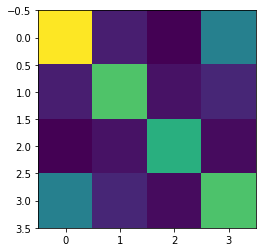

In [3]:
# plot sigma
plt.imshow(sigma, interpolation='nearest')
plt.show()

In [4]:
q = 0.5                   # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets      # set parameter to scale the budget penalty term

qubitOp, offset = portfolio.get_operator(mu, sigma, q, budget, penalty)

We define some utility methods to print the results in a nice format.

In [5]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x

def print_result(result):
    selection = sample_most_likely(result.eigenstate)
    value = portfolio.portfolio_value(selection, mu, sigma, q, budget, penalty)
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))
        
    eigenvector = result.eigenstate if isinstance(result.eigenstate, np.ndarray) else result.eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = portfolio.portfolio_value(x, mu, sigma, q, budget, penalty)    
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))

## NumPyMinimumEigensolver (as a classical reference)
Lets solve the problem. First classically...

We can now use the Operator we built above without regard to the specifics of how it was created. We set the algorithm for the NumPyMinimumEigensolver so we can have a classical reference. The problem is set for 'ising'. Backend is not required since this is computed classically not using quantum computation. The result is returned as a dictionary.

In [6]:
exact_eigensolver = NumPyMinimumEigensolver(qubitOp)
result = exact_eigensolver.run()

print_result(result)

Optimal: selection [0 1 0 1], value -0.0005

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 0 1]	-0.0005		1.0000
 [1 1 1 1]	16.0040		0.0000
 [0 1 1 1]	4.0013		0.0000
 [1 0 1 1]	4.0052		0.0000
 [0 0 1 1]	0.0025		0.0000
 [1 1 0 1]	4.0023		0.0000
 [1 0 0 1]	0.0034		0.0000
 [0 0 0 1]	4.0007		0.0000
 [1 1 1 0]	4.0033		0.0000
 [0 1 1 0]	0.0007		0.0000
 [1 0 1 0]	0.0045		0.0000
 [0 0 1 0]	4.0018		0.0000
 [1 1 0 0]	0.0016		0.0000
 [0 1 0 0]	3.9988		0.0000
 [1 0 0 0]	4.0027		0.0000
 [0 0 0 0]	16.0000		0.0000


## Solution using VQE
We can now use the Variational Quantum Eigensolver (VQE) to solve the problem. We will specify the optimizer and variational form to be used.

Note: You can switch to different backends by providing the name of backend.

In [7]:
backend = Aer.get_backend('statevector_simulator')
seed = 50

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=3, entanglement='full')
vqe = VQE(qubitOp, ry, cobyla)
vqe.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

print_result(result)

Optimal: selection [0. 0. 1. 1.], value 0.0025

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 0 1 1]	0.0025		0.7519
 [0 1 1 0]	0.0007		0.2480
 [1 1 0 1]	4.0023		0.0000
 [1 1 0 0]	0.0016		0.0000
 [1 0 0 1]	0.0034		0.0000
 [0 1 0 1]	-0.0005		0.0000
 [1 1 1 0]	4.0033		0.0000
 [1 0 0 0]	4.0027		0.0000
 [1 0 1 1]	4.0052		0.0000
 [1 0 1 0]	0.0045		0.0000
 [0 0 1 0]	4.0018		0.0000
 [0 1 0 0]	3.9988		0.0000
 [0 0 0 1]	4.0007		0.0000
 [0 1 1 1]	4.0013		0.0000
 [0 0 0 0]	16.0000		0.0000
 [1 1 1 1]	16.0040		0.0000


### Solution using QAOA

We also show here a result using the Quantum Approximate Optimization Algorithm (QAOA). This is another variational algorithm and it uses an internal variational form that is created based on the problem.

In [8]:
backend = Aer.get_backend('statevector_simulator')
seed = 50

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa = QAOA(qubitOp, cobyla, 3)

qaoa.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

result = qaoa.run(quantum_instance)

print_result(result)

Optimal: selection [0. 1. 0. 1.], value -0.0005

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 0 1]	-0.0005		0.1673
 [0 1 1 0]	0.0007		0.1670
 [1 1 0 0]	0.0016		0.1668
 [0 0 1 1]	0.0025		0.1666
 [1 0 0 1]	0.0034		0.1663
 [1 0 1 0]	0.0045		0.1661
 [1 1 1 1]	16.0040		0.0000
 [0 0 0 0]	16.0000		0.0000
 [0 1 1 1]	4.0013		0.0000
 [0 1 0 0]	3.9988		0.0000
 [1 1 0 1]	4.0023		0.0000
 [1 0 1 1]	4.0052		0.0000
 [1 0 0 0]	4.0027		0.0000
 [1 1 1 0]	4.0033		0.0000
 [0 0 0 1]	4.0007		0.0000
 [0 0 1 0]	4.0018		0.0000


In [9]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright